In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show  # noqa: E402
from utils.optimization import load_model_params_from_json  # noqa: E402
from utils.models import eval_poly  # noqa: E402

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated/'

# Parameters

In [2]:
solar_boat_params = load_model_params_from_json(
    "../../../models/2020/boat/solar_boat_params.json"
)
solar_boat_params

{'batt_C_1': 763.5350737712305,
 'batt_C_2': 212113.61911925237,
 'batt_N_S': 3,
 'batt_Q': 172800,
 'batt_R_0': 0.004833021318920369,
 'batt_R_1': 0.005009783862137879,
 'batt_R_2': 0.09739310817004393,
 'batt_eta': 1,
 'batt_k_V_OC_coeffs': array([10.78645833,  3.58638935, -3.07530114,  1.61637218]),
 'esc_E_off': 0.00011,
 'esc_E_on': 7e-05,
 'esc_F_s': 12550,
 'esc_Q_rr': 1.9e-07,
 'esc_R_ds_on': 0.006428129677311848,
 'esc_V_F': 2.884681806089211,
 'esc_V_ds_ov': 1.2222222222222223,
 'esc_R_D': 0.003448696395697723,
 'hull_C_T': 0.010164657977504103,
 'hull_M': 293.7,
 'hull_M_a': 0.13930375506724846,
 'hull_S_air': 4.188174709710495,
 'hull_S_water': 4.050226176680205,
 'hull_T_ded': 0.048239289362583315,
 'hull_W': 0.09274643880385036,
 'motor_B': 0.001401819826389131,
 'motor_I_r': 0.011815137847671575,
 'motor_I_r_load': 0,
 'motor_K_Q': 0.10638460838741098,
 'motor_K_V': 0.10178006369696158,
 'motor_L_A': 6.24949639106588e-05,
 'motor_R_A': 0.0195442230227981,
 'mppt_eta': 0.

# Solar Boat System model

In [3]:
from model import SolarBoatFull

SolarBoatFull.build(solar_boat_params)

<NonlinearIOSystem solarboat_full: ['pv_g', 'esc_d'] -> ['batt_v', 'batt_i', 'batt_v_C_1', 'batt_v_C_2', 'batt_z', 'batt_v_oc', 'batt_p_out', 'batt_p_in', 'pv_p_in', 'pv_p_out', 'pv_eta', 'pv_g', 'mppt1_i_in', 'mppt1_v_in', 'mppt1_p_in', 'mppt1_v_out', 'mppt1_i_out', 'mppt1_p_out', 'mppt2_i_in', 'mppt2_v_in', 'mppt2_p_in', 'mppt2_v_out', 'mppt2_i_out', 'mppt2_p_out', 'mppt3_i_in', 'mppt3_v_in', 'mppt3_p_in', 'mppt3_v_out', 'mppt3_i_out', 'mppt3_p_out', 'mppt4_i_in', 'mppt4_v_in', 'mppt4_p_in', 'mppt4_v_out', 'mppt4_i_out', 'mppt4_p_out', 'pvs_p_in', 'pvs_p_out', 'pvs_i_out', 'mppt_p_in', 'mppt_p_out', 'mppt_v_in', 'mppt_v_out', 'mppt_i_in', 'mppt_i_out', 'mppt_eta', 'mppts_p_in', 'mppts_p_out', 'mppts_i_out', 'esc_v_in', 'esc_v_out', 'esc_i_in', 'esc_i_out', 'esc_p_in', 'esc_p_out', 'esc_eta', 'esc_p_loss', 'esc_p_M_cond', 'esc_p_D_cond', 'esc_p_M_sw', 'esc_p_D_sw', 'esc_i_M_RMS', 'esc_i_D_RMS', 'esc_i_D_AVG', 'motor_i', 'motor_v', 'motor_w', 'motor_q_load', 'motor_p_in', 'motor_p_out'

# Example of comparing a change in the transmission system, using the same propeller


In [4]:
from datetime import timedelta, datetime
import numpy as np
import pandas as pd


initial_SOC = 1

start_date = datetime(year=2024, month=6, day=16, hour=10)
race_duration = timedelta(minutes=1)
timestamp = pd.date_range(start=start_date, end=start_date + race_duration, freq='s')

irradiation = 0
pv_g = np.ones(timestamp.shape) * irradiation

esc_d = np.linspace(0, 1, timestamp.size)

df = pd.DataFrame(dict(timestamp=timestamp, pv_g=pv_g, esc_d=esc_d)).set_index('timestamp')
df


,pv_g,esc_d
timestamp,,
2024-06-16 10:00:00,0.0,0.000000
2024-06-16 10:00:01,0.0,0.016667
2024-06-16 10:00:02,0.0,0.033333
2024-06-16 10:00:03,0.0,0.050000
2024-06-16 10:00:04,0.0,0.066667
...,...,...
2024-06-16 10:00:56,0.0,0.933333
2024-06-16 10:00:57,0.0,0.950000
2024-06-16 10:00:58,0.0,0.966667


In [5]:
# Input data
T_step = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9
lenT = len(df.index)
T = np.linspace(0, lenT * T_step, lenT, endpoint=False)

input_cols = SolarBoatFull.build(solar_boat_params).input_labels
U = df[input_cols].copy(deep=True).to_numpy().T

# Initial state (match SolarBoatFull.initial_state requirements)
initial_batt_z = float(initial_SOC)
initial_batt_v = float(solar_boat_params['batt_N_S']) * float(
    eval_poly(solar_boat_params['batt_k_V_OC_coeffs'], initial_batt_z)
)

X0 = SolarBoatFull.initial_state(
    X0={'batt_z': initial_batt_z, 'batt_v': initial_batt_v},
    U0=U[:, 0],
    params=solar_boat_params,
)

def simulate_transmission(params: dict) -> pd.DataFrame:
    return ct.input_output_response(
        SolarBoatFull.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas().set_index('time')

solar_boat_params_1 = solar_boat_params.copy()
solar_boat_params_1['trans_k'] = 14 / 22
results_transmission_1 = simulate_transmission(solar_boat_params_1).copy()  # note: copy to solve fragmentation in the dataframe

solar_boat_params_2 = solar_boat_params.copy()
solar_boat_params_2['trans_k'] = 1
results_transmission_2 = simulate_transmission(solar_boat_params_2).copy()  # note: copy to solve fragmentation in the dataframe

solar_boat_params_3 = solar_boat_params.copy()
solar_boat_params_3['trans_k'] = 1 / 2
results_transmission_3 = simulate_transmission(solar_boat_params_3).copy()  # note: copy to solve fragmentation in the dataframe

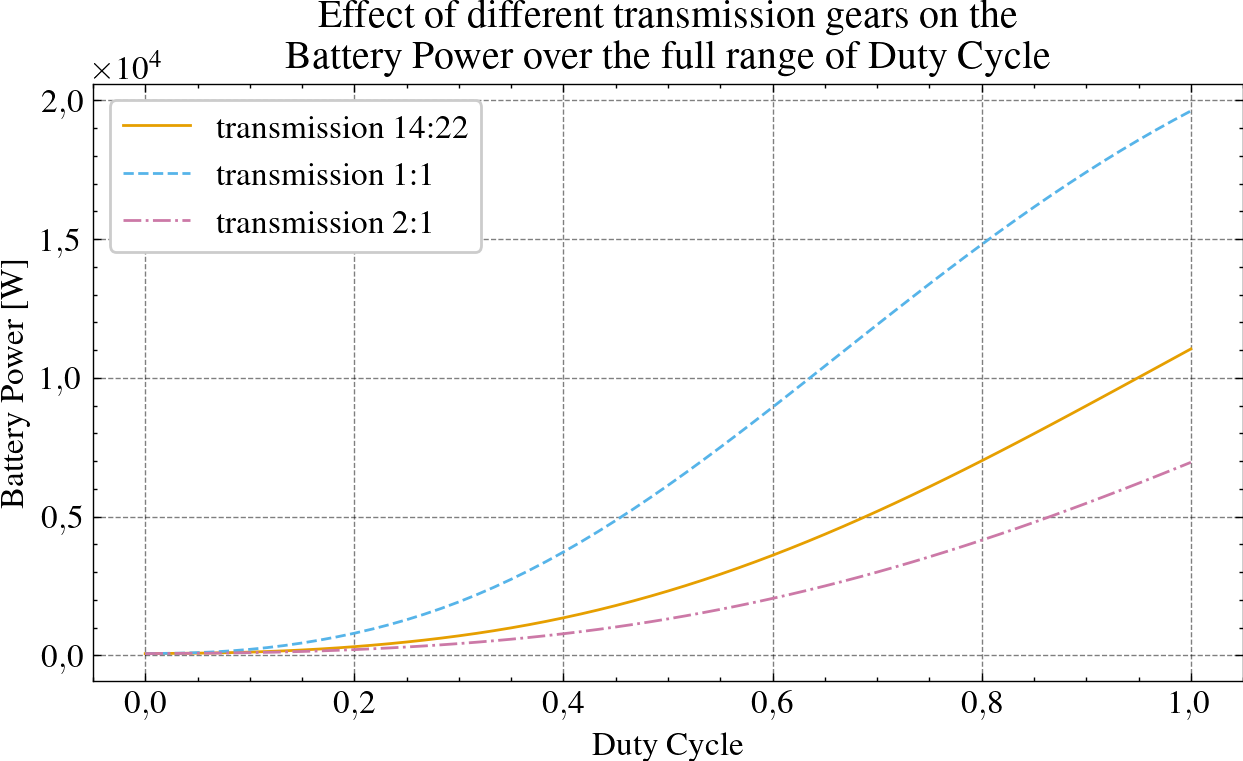

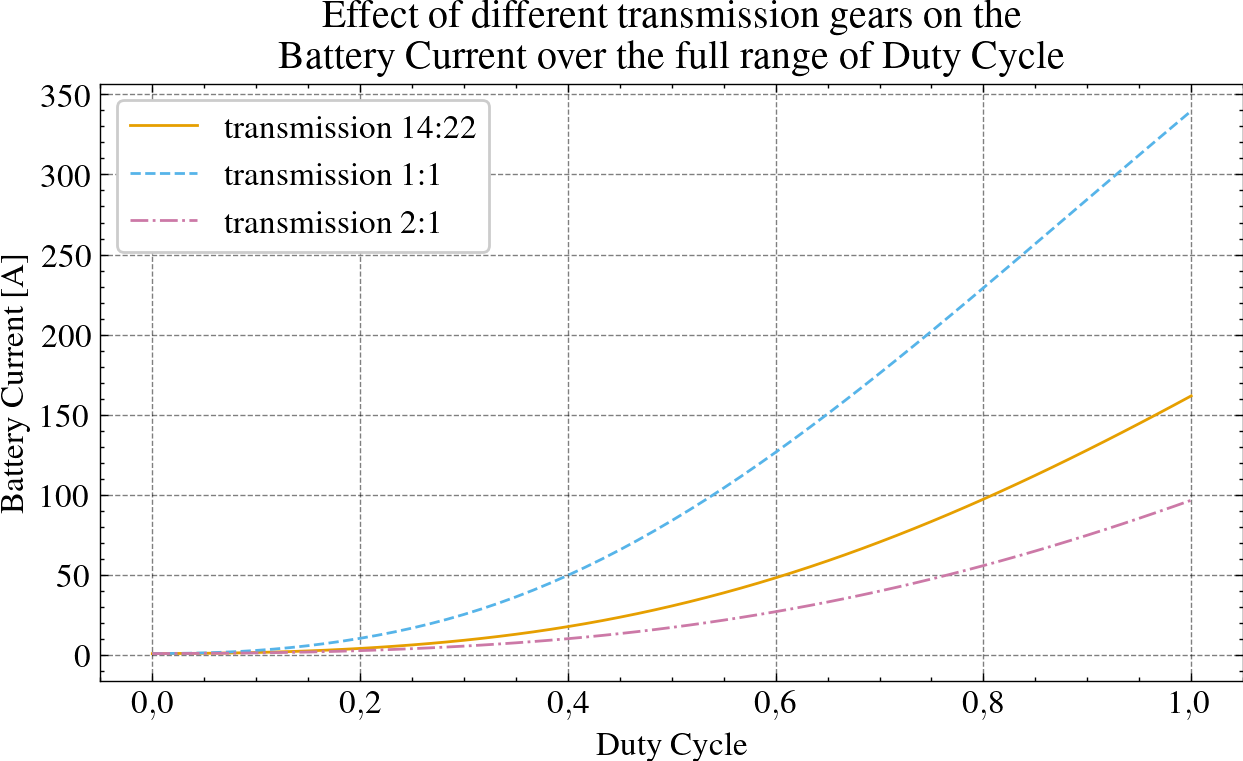

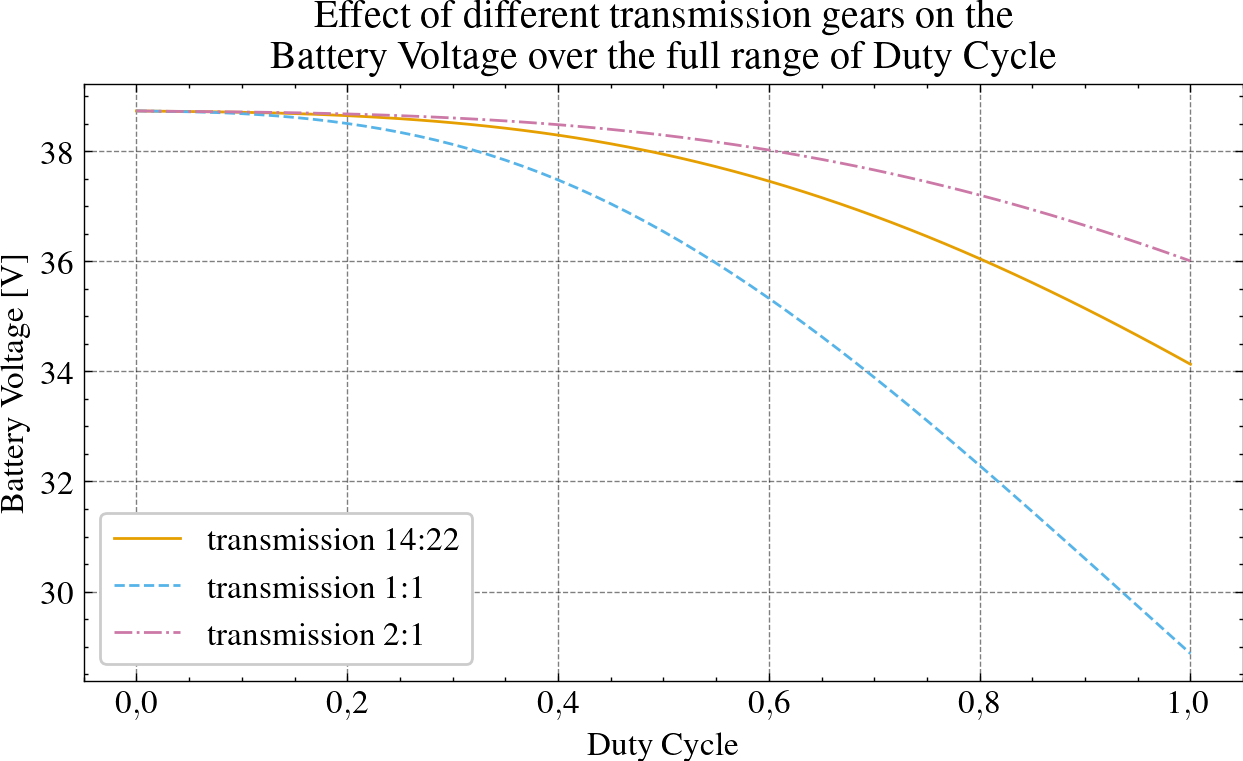

In [6]:
results_transmission_1['batt_p'] = results_transmission_1['batt_p_out'] - results_transmission_1['batt_p_in']
results_transmission_2['batt_p'] = results_transmission_2['batt_p_out'] - results_transmission_2['batt_p_in']
results_transmission_3['batt_p'] = results_transmission_3['batt_p_out'] - results_transmission_3['batt_p_in']

plt.figure()
plt.plot(results_transmission_1['esc_d'], results_transmission_1['batt_p'], label='transmission 14:22')
plt.plot(results_transmission_2['esc_d'], results_transmission_2['batt_p'], label='transmission 1:1')
plt.plot(results_transmission_3['esc_d'], results_transmission_3['batt_p'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Battery Power [W]")
plt.title("Effect of different transmission gears on the \nBattery Power over the full range of Duty Cycle")
plt.legend()
plt.show();

plt.figure()
plt.plot(results_transmission_1['esc_d'], results_transmission_1['batt_i'], label='transmission 14:22')
plt.plot(results_transmission_2['esc_d'], results_transmission_2['batt_i'], label='transmission 1:1')
plt.plot(results_transmission_3['esc_d'], results_transmission_3['batt_i'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Battery Current [A]")
plt.title("Effect of different transmission gears on the \nBattery Current over the full range of Duty Cycle")
plt.legend()
plt.show();

plt.figure()
plt.plot(results_transmission_1['esc_d'], results_transmission_1['batt_v'], label='transmission 14:22')
plt.plot(results_transmission_2['esc_d'], results_transmission_2['batt_v'], label='transmission 1:1')
plt.plot(results_transmission_3['esc_d'], results_transmission_3['batt_v'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Battery Voltage [V]")
plt.title("Effect of different transmission gears on the \nBattery Voltage over the full range of Duty Cycle")
plt.legend()
plt.show();


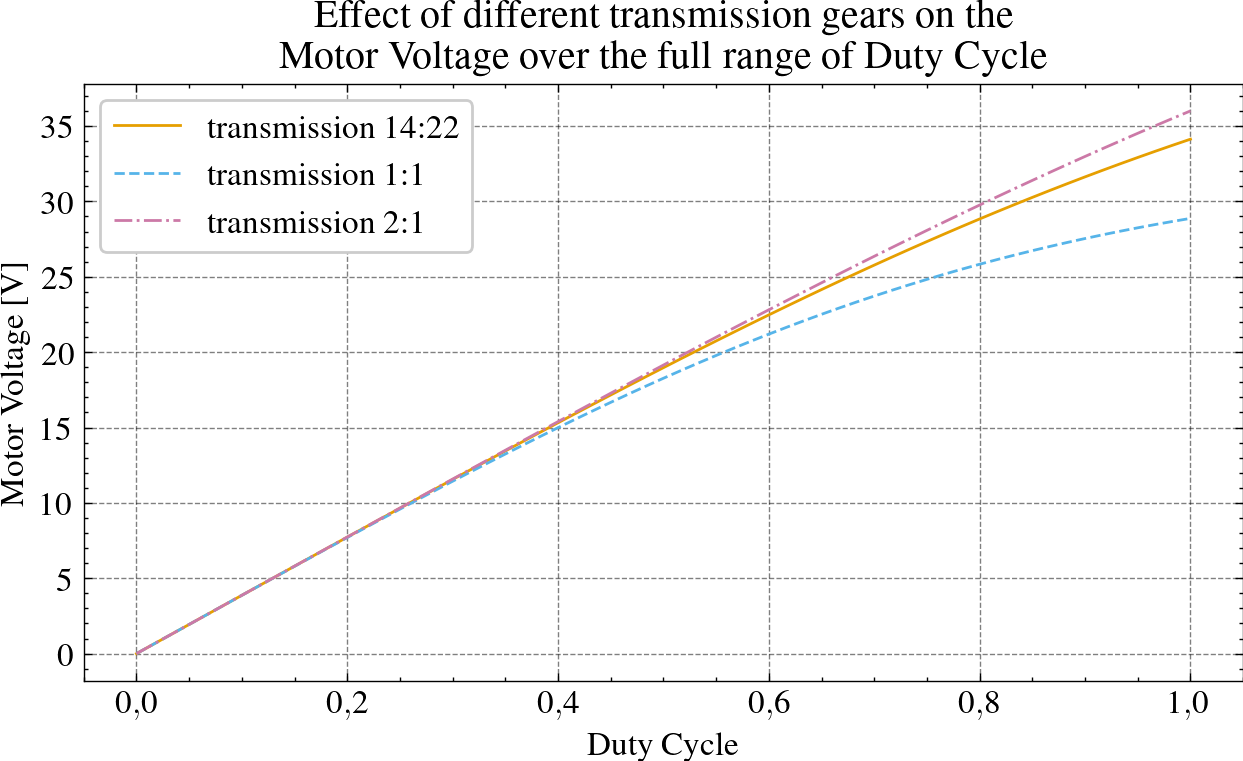

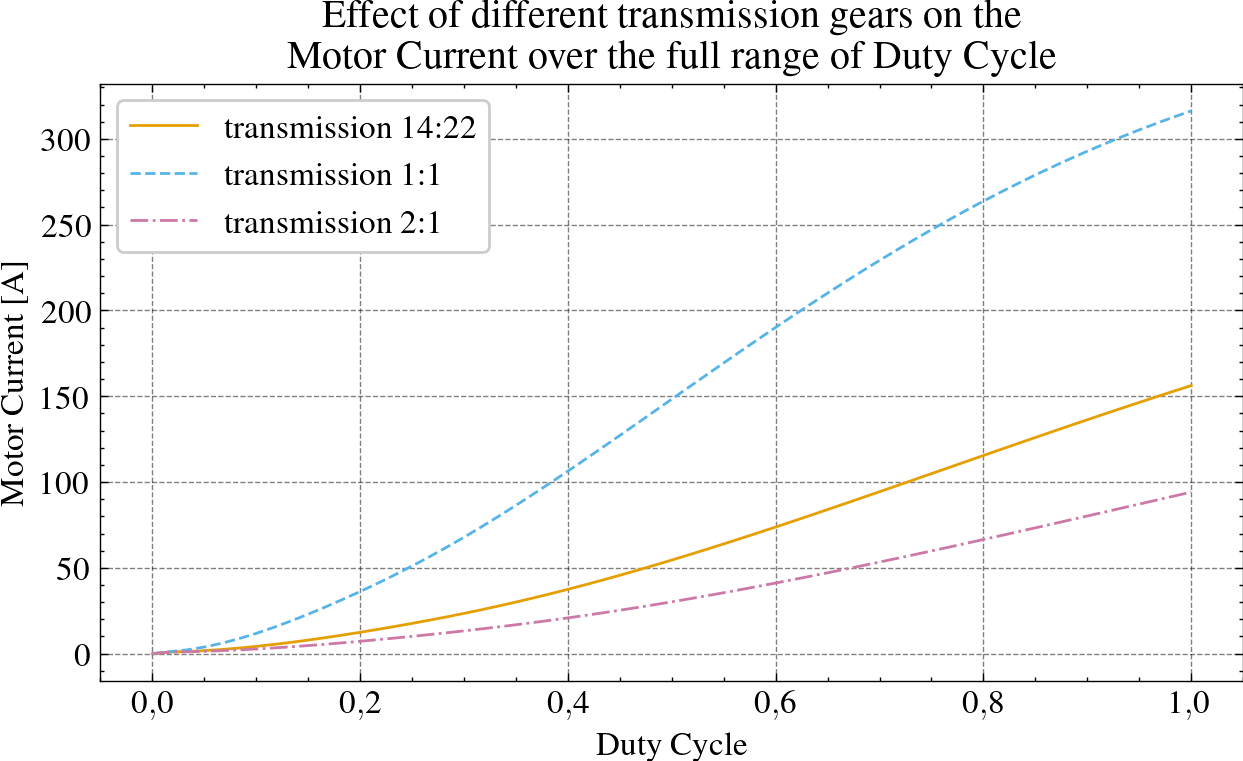

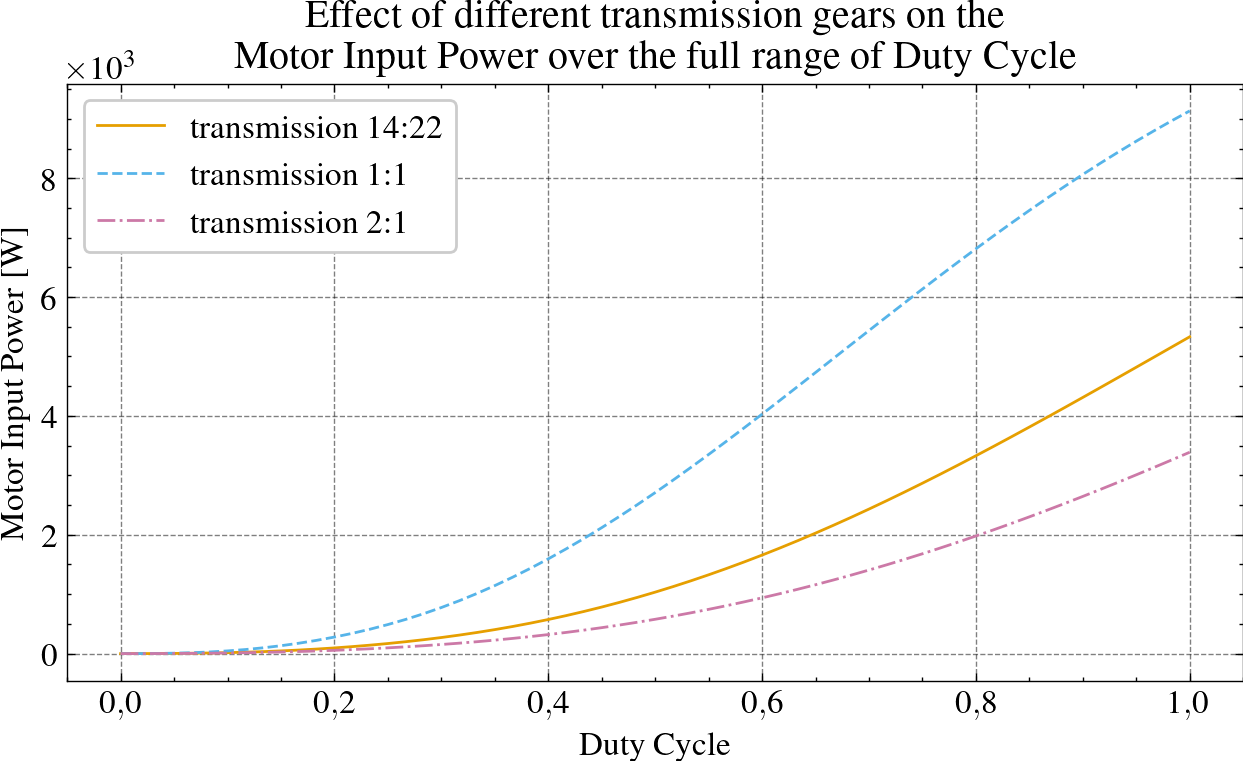

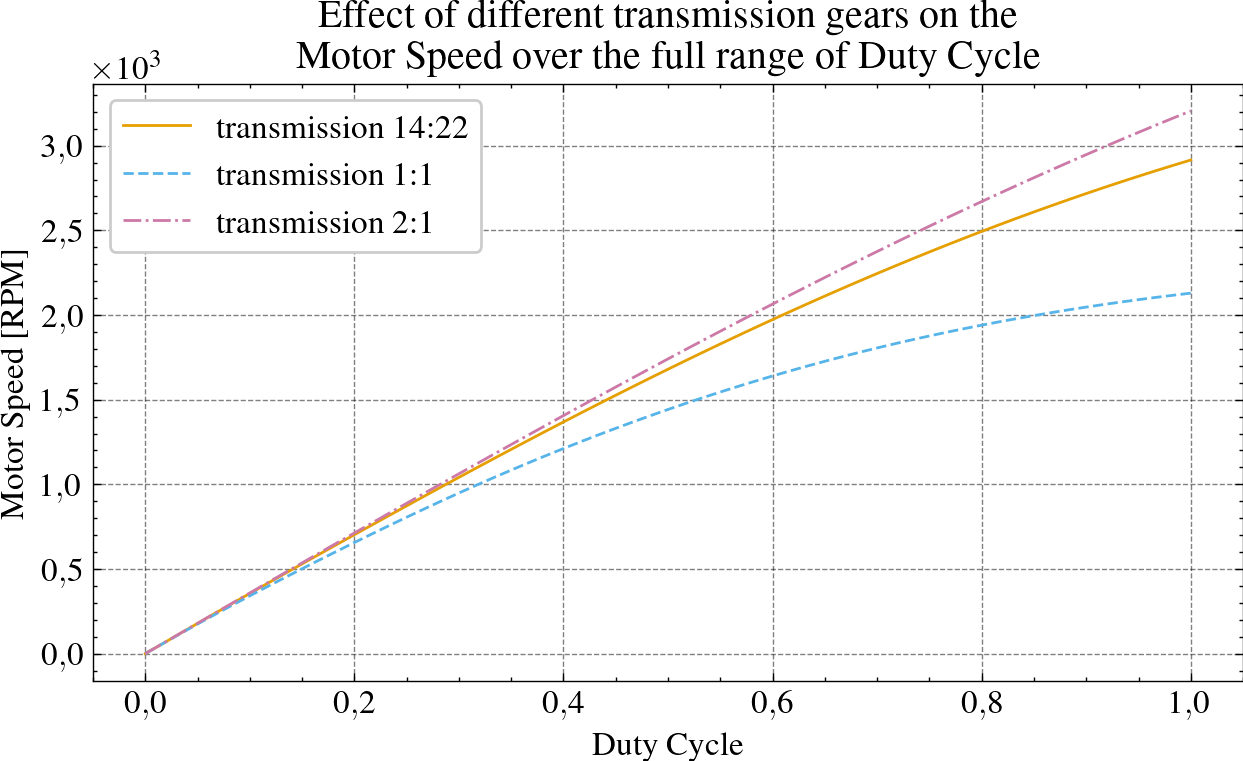

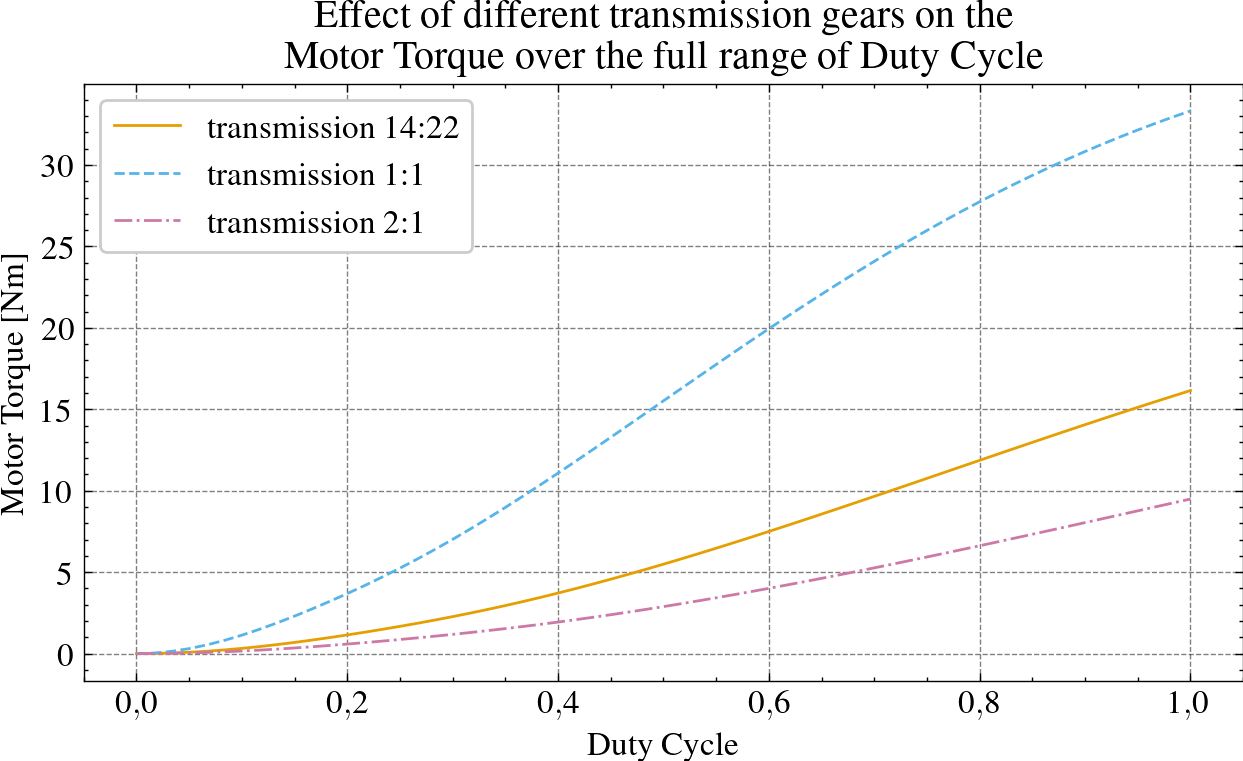

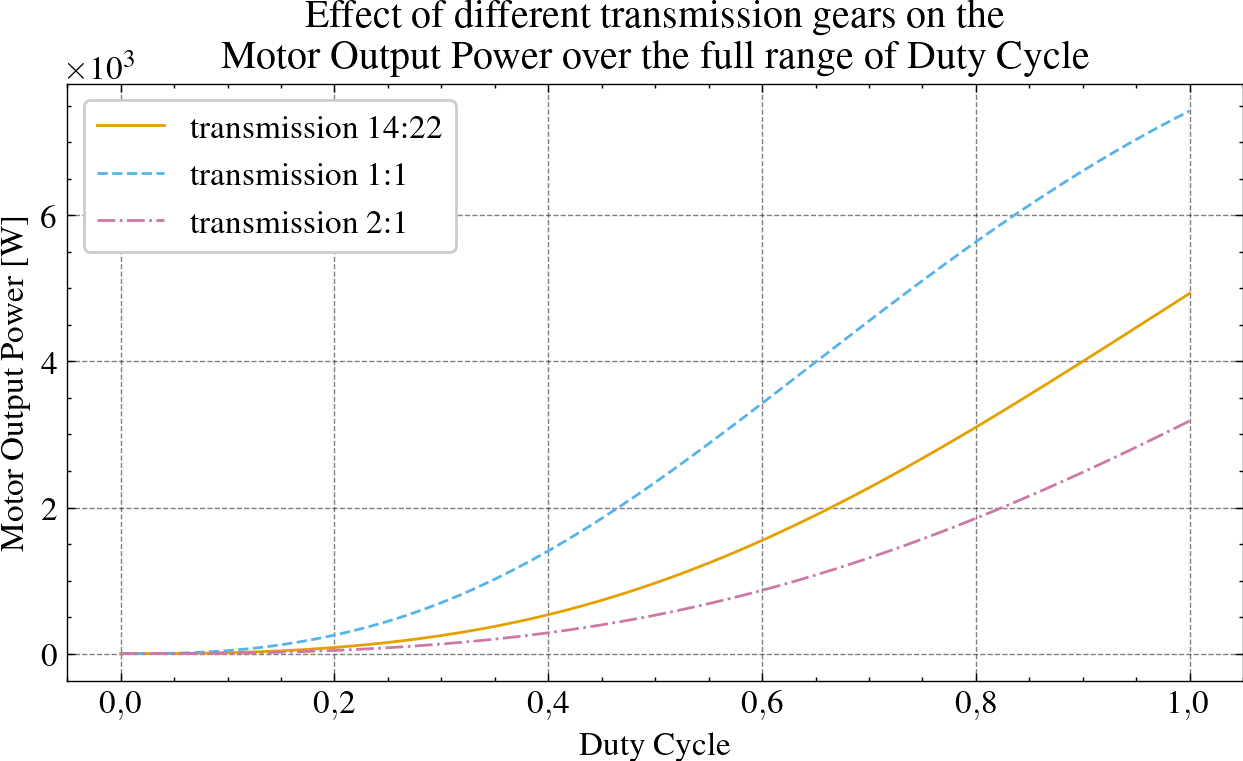

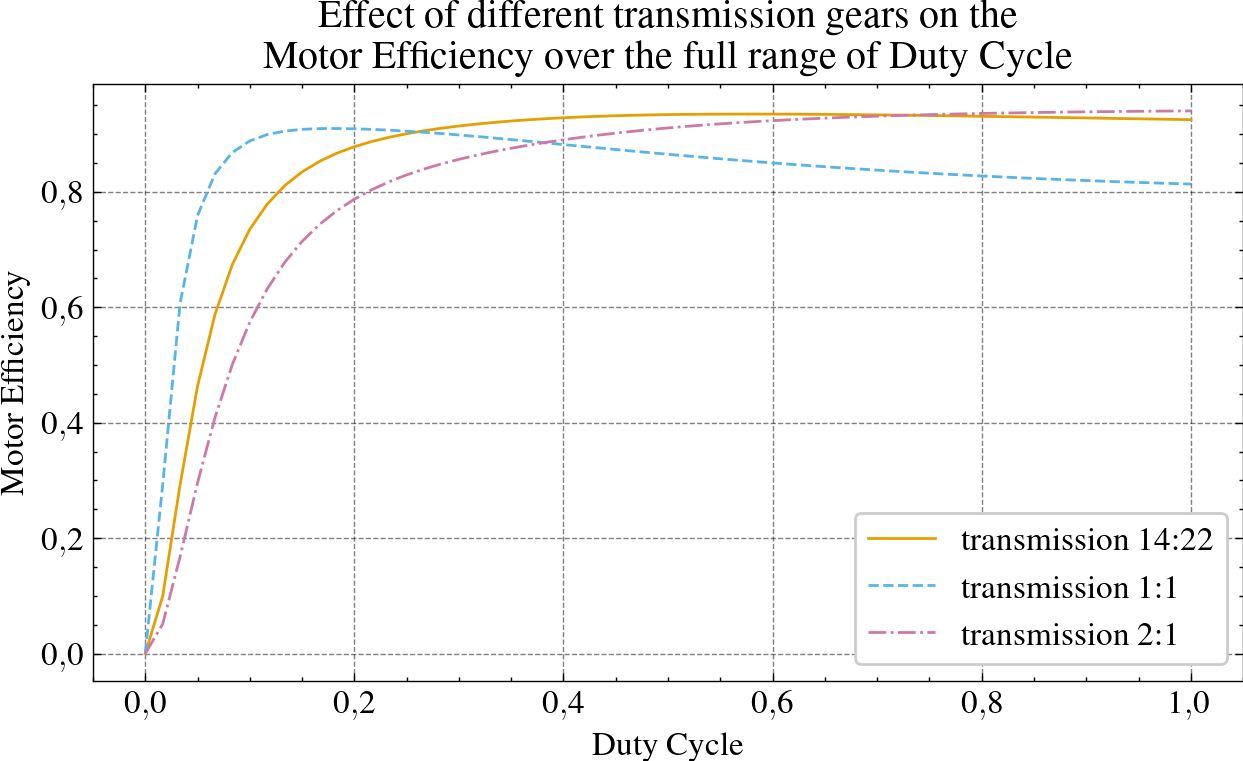

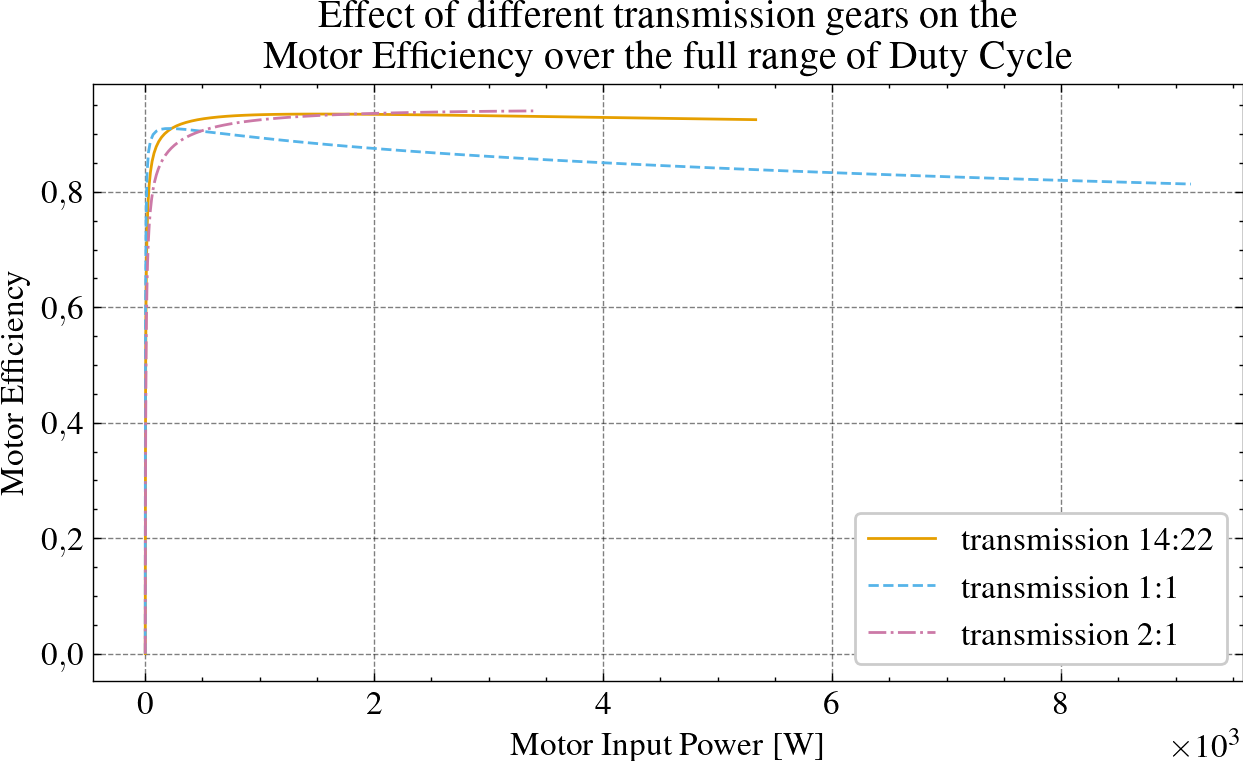

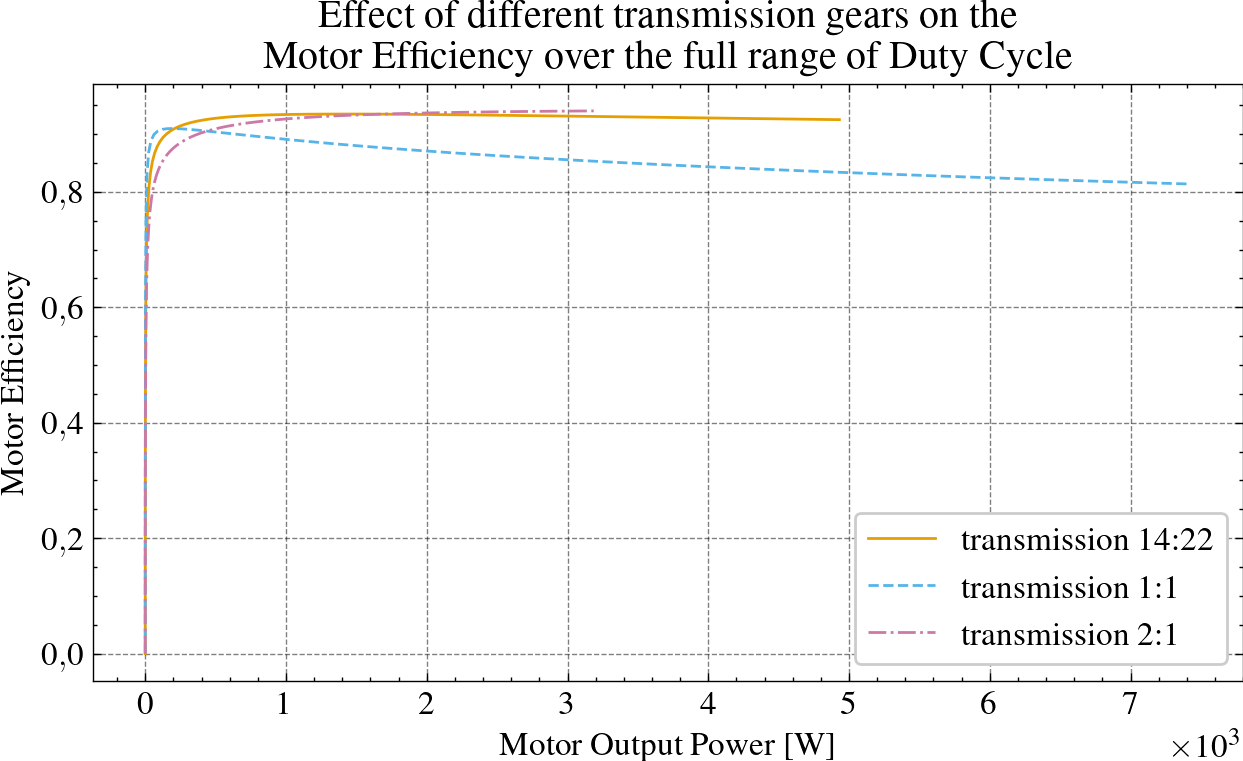

In [7]:
plt.figure()
plt.plot(results_transmission_1['esc_d'], results_transmission_1['motor_v'], label='transmission 14:22')
plt.plot(results_transmission_2['esc_d'], results_transmission_2['motor_v'], label='transmission 1:1')
plt.plot(results_transmission_3['esc_d'], results_transmission_3['motor_v'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Motor Voltage [V]")
plt.title("Effect of different transmission gears on the \nMotor Voltage over the full range of Duty Cycle")
plt.legend()
plt.show();

plt.figure()
plt.plot(results_transmission_1['esc_d'], results_transmission_1['motor_i'], label='transmission 14:22')
plt.plot(results_transmission_2['esc_d'], results_transmission_2['motor_i'], label='transmission 1:1')
plt.plot(results_transmission_3['esc_d'], results_transmission_3['motor_i'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Motor Current [A]")
plt.title("Effect of different transmission gears on the \nMotor Current over the full range of Duty Cycle")
plt.legend()
plt.show();

plt.figure()
plt.plot(results_transmission_1['esc_d'], results_transmission_1['motor_p_in'], label='transmission 14:22')
plt.plot(results_transmission_2['esc_d'], results_transmission_2['motor_p_in'], label='transmission 1:1')
plt.plot(results_transmission_3['esc_d'], results_transmission_3['motor_p_in'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Motor Input Power [W]")
plt.title("Effect of different transmission gears on the \nMotor Input Power over the full range of Duty Cycle")
plt.legend()
plt.show();


plt.figure()
plt.plot(results_transmission_1['esc_d'], results_transmission_1['motor_w'] * 30 / np.pi, label='transmission 14:22')
plt.plot(results_transmission_2['esc_d'], results_transmission_2['motor_w'] * 30 / np.pi, label='transmission 1:1')
plt.plot(results_transmission_3['esc_d'], results_transmission_3['motor_w'] * 30 / np.pi, label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Motor Speed [RPM]")
plt.title("Effect of different transmission gears on the \nMotor Speed over the full range of Duty Cycle")
plt.legend()
plt.show();

plt.figure()
plt.plot(results_transmission_1['esc_d'], results_transmission_1['motor_q_load'], label='transmission 14:22')
plt.plot(results_transmission_2['esc_d'], results_transmission_2['motor_q_load'], label='transmission 1:1')
plt.plot(results_transmission_3['esc_d'], results_transmission_3['motor_q_load'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Motor Torque [Nm]")
plt.title("Effect of different transmission gears on the \nMotor Torque over the full range of Duty Cycle")
plt.legend()
plt.show();

plt.figure()
plt.plot(results_transmission_1['esc_d'], results_transmission_1['motor_p_out'], label='transmission 14:22')
plt.plot(results_transmission_2['esc_d'], results_transmission_2['motor_p_out'], label='transmission 1:1')
plt.plot(results_transmission_3['esc_d'], results_transmission_3['motor_p_out'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Motor Output Power [W]")
plt.title("Effect of different transmission gears on the \nMotor Output Power over the full range of Duty Cycle")
plt.legend()
plt.show();

plt.figure()
plt.plot(results_transmission_1['esc_d'], results_transmission_1['motor_eta'], label='transmission 14:22')
plt.plot(results_transmission_2['esc_d'], results_transmission_2['motor_eta'], label='transmission 1:1')
plt.plot(results_transmission_3['esc_d'], results_transmission_3['motor_eta'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Motor Efficiency")
plt.title("Effect of different transmission gears on the \nMotor Efficiency over the full range of Duty Cycle")
plt.legend()
plt.show();

plt.figure()
plt.plot(results_transmission_1['motor_p_in'], results_transmission_1['motor_eta'], label='transmission 14:22')
plt.plot(results_transmission_2['motor_p_in'], results_transmission_2['motor_eta'], label='transmission 1:1')
plt.plot(results_transmission_3['motor_p_in'], results_transmission_3['motor_eta'], label='transmission 2:1')
plt.xlabel("Motor Input Power [W]")
plt.ylabel("Motor Efficiency")
plt.title("Effect of different transmission gears on the \nMotor Efficiency over the full range of Duty Cycle")
plt.legend()
plt.show();

plt.figure()
plt.plot(results_transmission_1['motor_p_out'], results_transmission_1['motor_eta'], label='transmission 14:22')
plt.plot(results_transmission_2['motor_p_out'], results_transmission_2['motor_eta'], label='transmission 1:1')
plt.plot(results_transmission_3['motor_p_out'], results_transmission_3['motor_eta'], label='transmission 2:1')
plt.xlabel("Motor Output Power [W]")
plt.ylabel("Motor Efficiency")
plt.title("Effect of different transmission gears on the \nMotor Efficiency over the full range of Duty Cycle")
plt.legend()
plt.show();

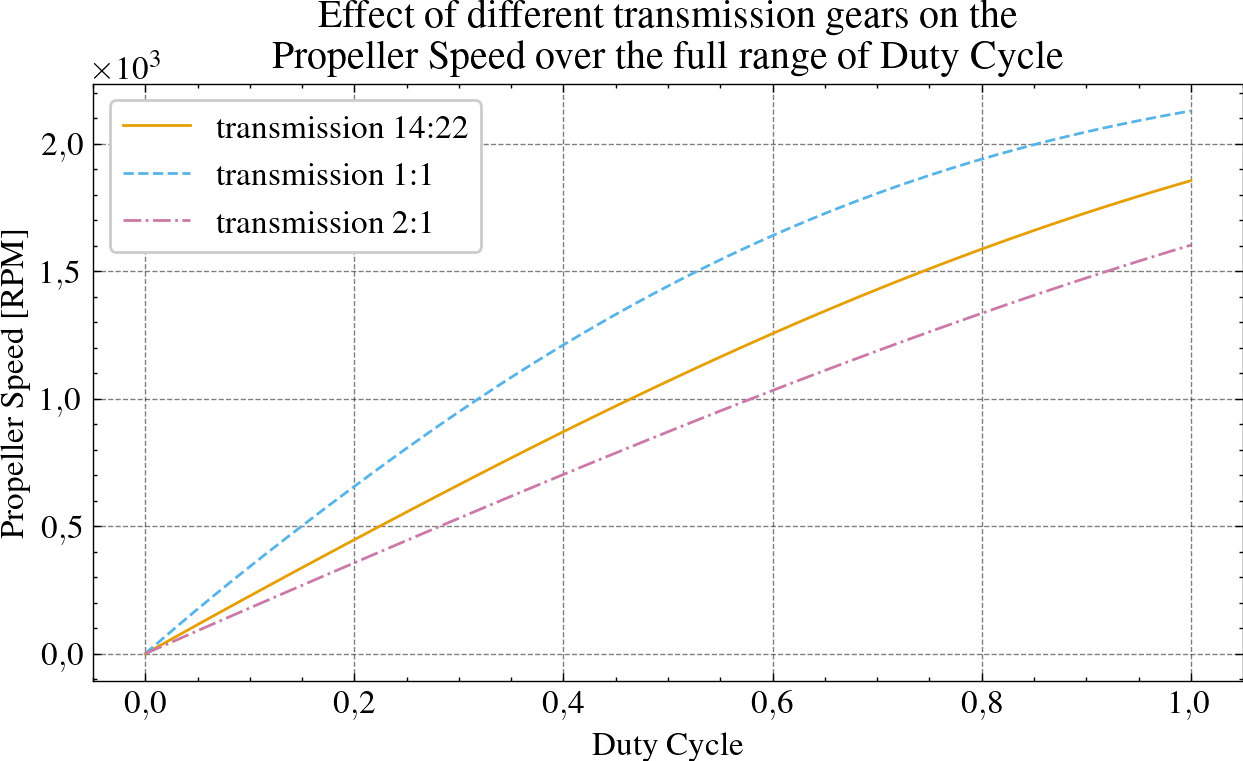

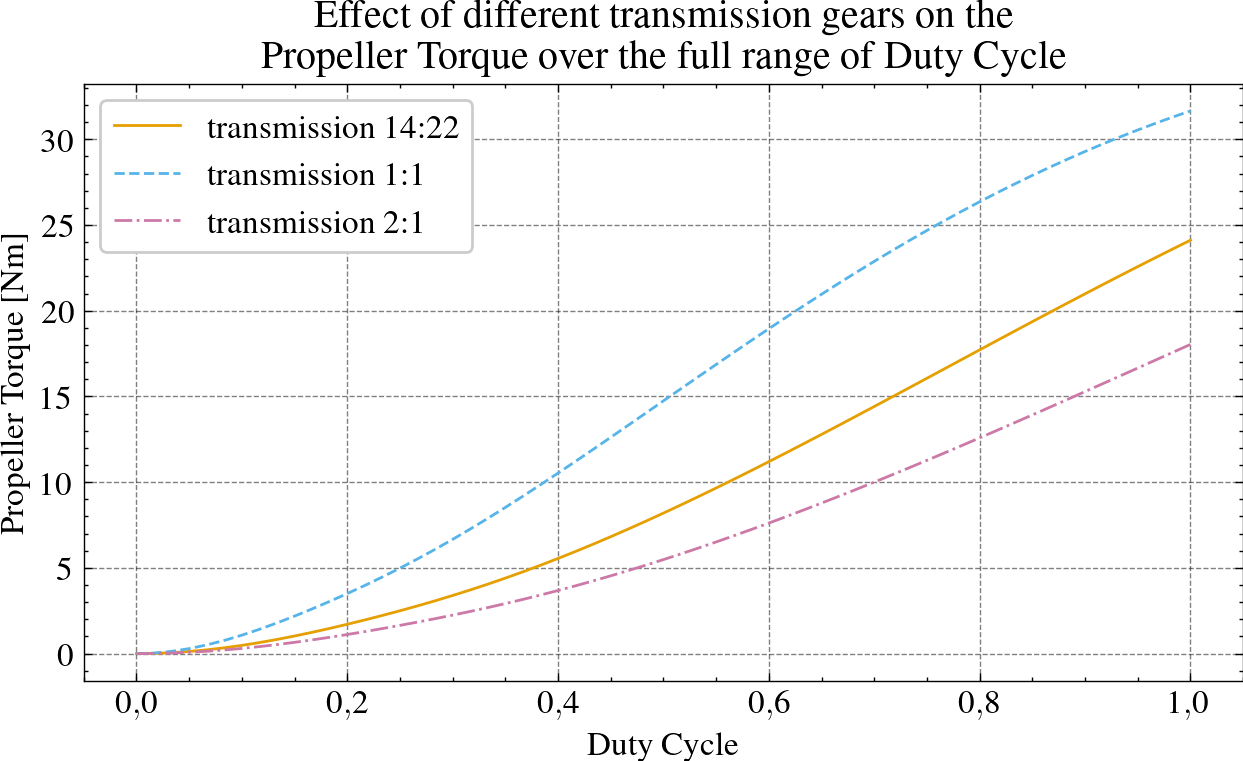

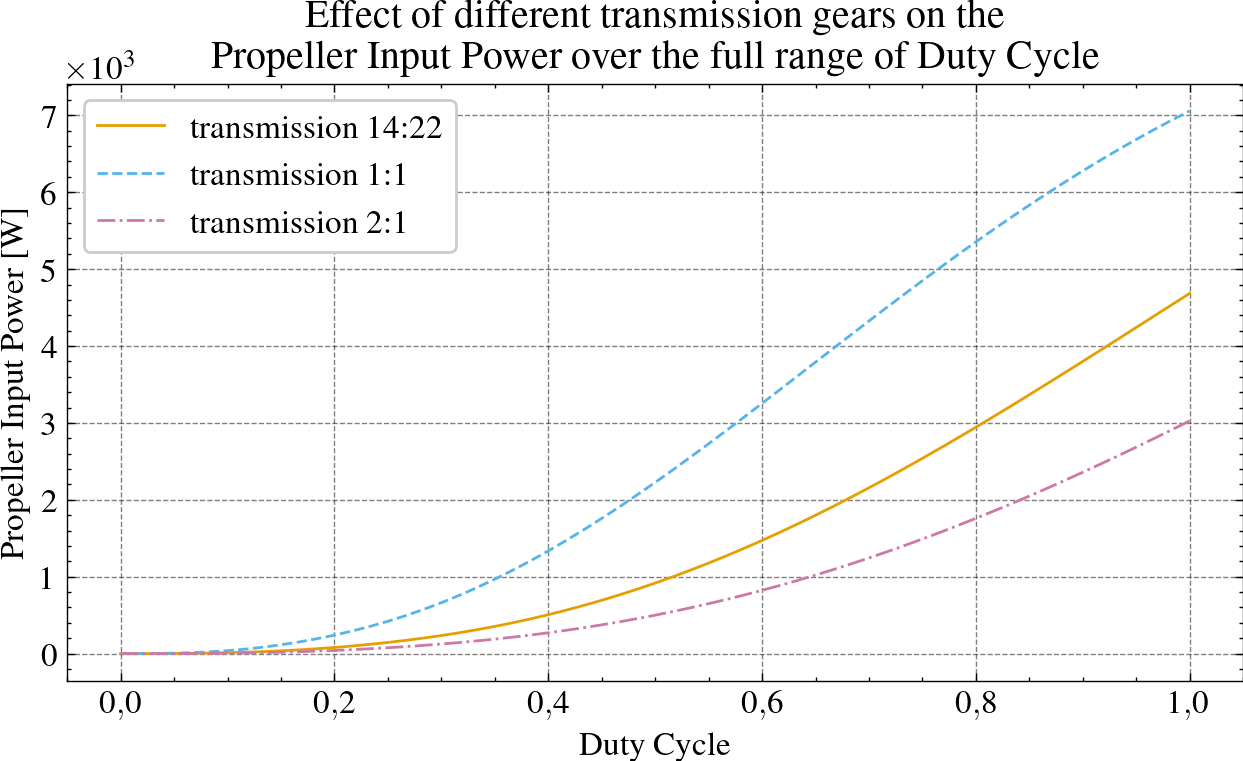

In [8]:
plt.figure()
plt.plot(results_transmission_1['esc_d'], results_transmission_1['prop_w'] * 30 / np.pi, label='transmission 14:22')
plt.plot(results_transmission_2['esc_d'], results_transmission_2['prop_w'] * 30 / np.pi, label='transmission 1:1')
plt.plot(results_transmission_3['esc_d'], results_transmission_3['prop_w'] * 30 / np.pi, label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Propeller Speed [RPM]")
plt.title("Effect of different transmission gears on the \nPropeller Speed over the full range of Duty Cycle")
plt.legend()
plt.show();

plt.figure()
plt.plot(results_transmission_1['esc_d'], results_transmission_1['prop_q'], label='transmission 14:22')
plt.plot(results_transmission_2['esc_d'], results_transmission_2['prop_q'], label='transmission 1:1')
plt.plot(results_transmission_3['esc_d'], results_transmission_3['prop_q'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Propeller Torque [Nm]")
plt.title("Effect of different transmission gears on the \nPropeller Torque over the full range of Duty Cycle")
plt.legend()
plt.show();

plt.figure()
plt.plot(results_transmission_1['esc_d'], results_transmission_1['prop_p_in'], label='transmission 14:22')
plt.plot(results_transmission_2['esc_d'], results_transmission_2['prop_p_in'], label='transmission 1:1')
plt.plot(results_transmission_3['esc_d'], results_transmission_3['prop_p_in'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Propeller Input Power [W]")
plt.title("Effect of different transmission gears on the \nPropeller Input Power over the full range of Duty Cycle")
plt.legend()
plt.show();

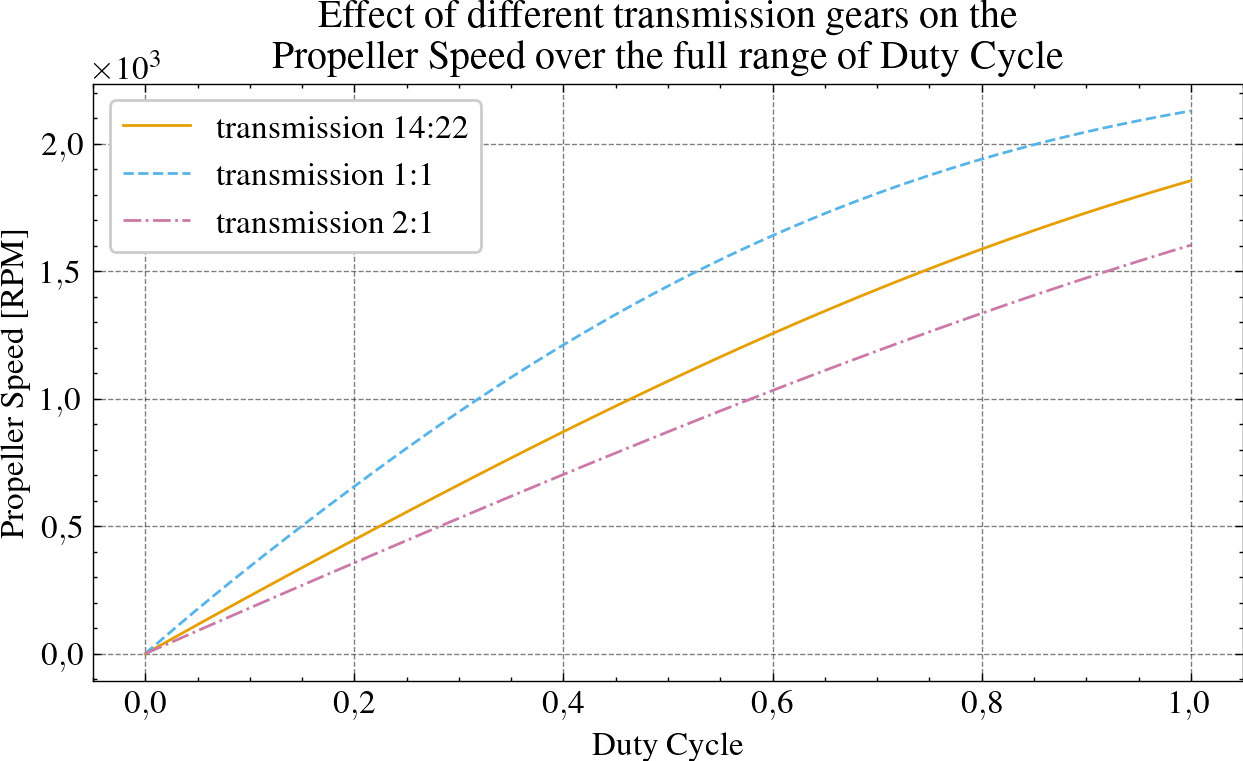

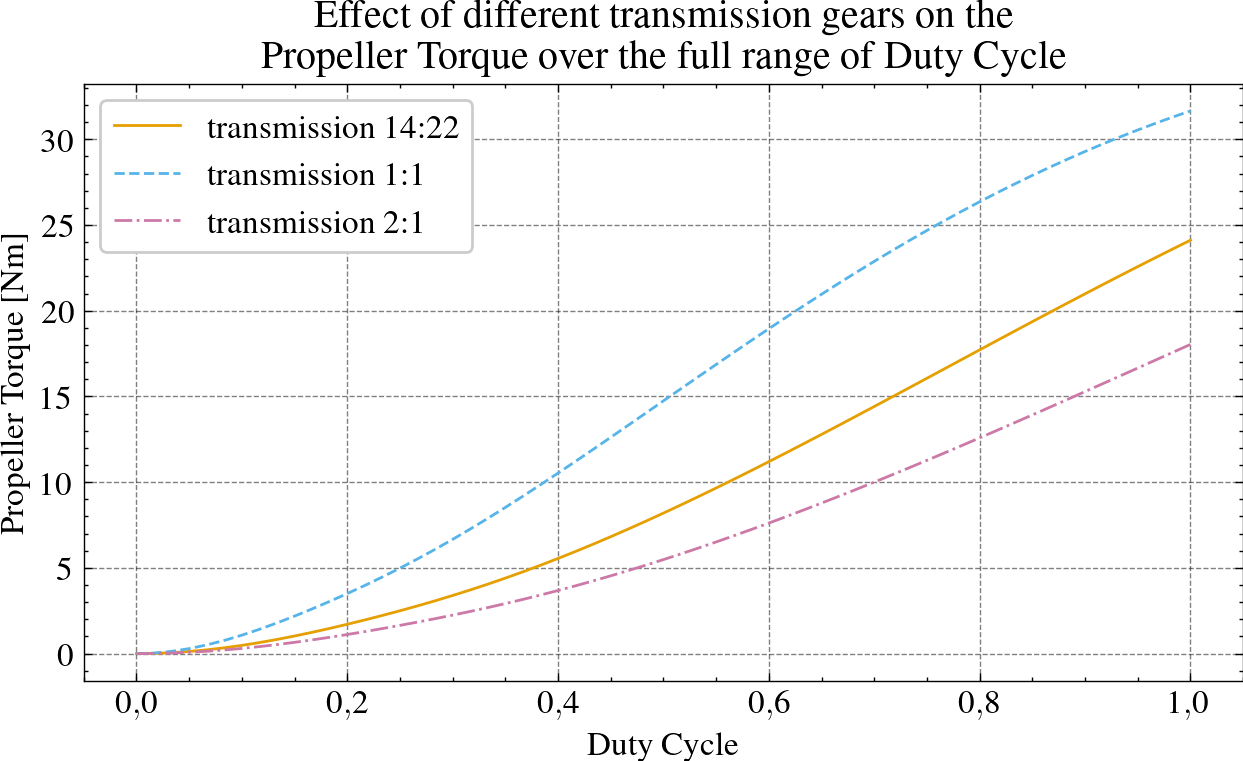

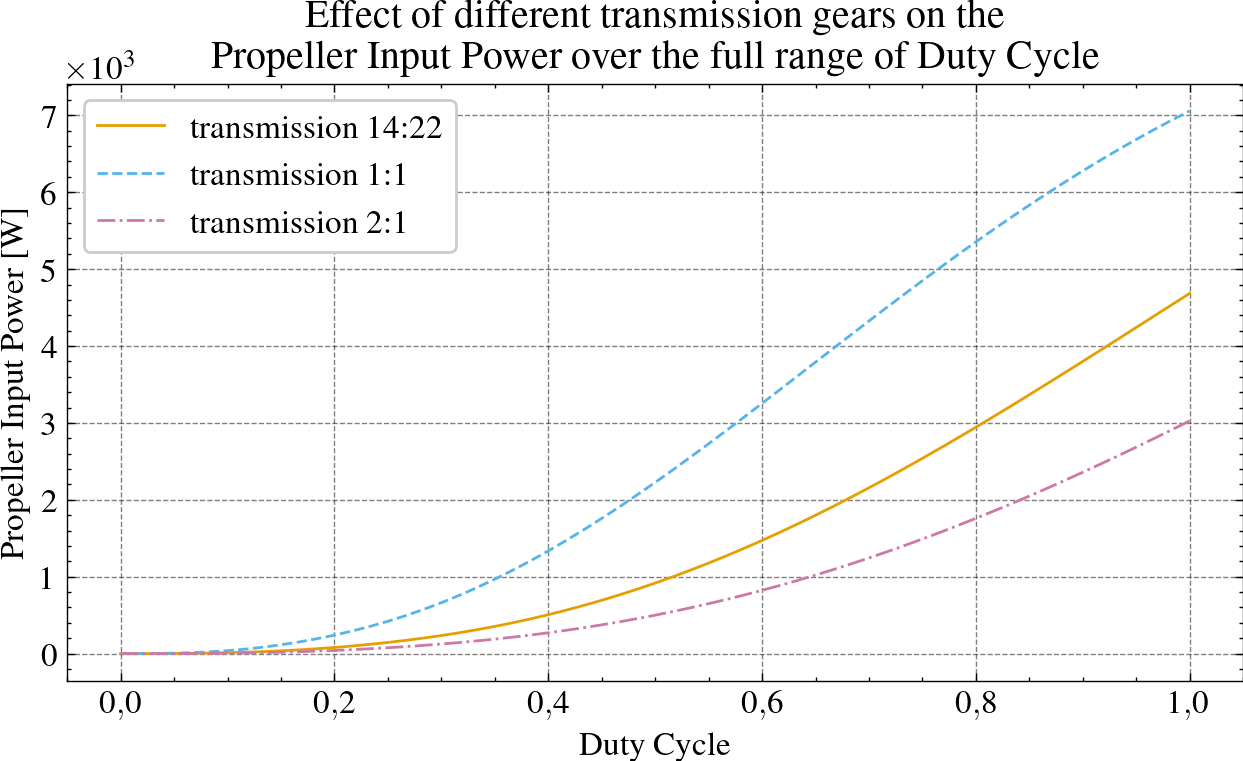

In [9]:
plt.figure()
plt.plot(results_transmission_1['esc_d'], results_transmission_1['prop_w'] * 30 / np.pi, label='transmission 14:22')
plt.plot(results_transmission_2['esc_d'], results_transmission_2['prop_w'] * 30 / np.pi, label='transmission 1:1')
plt.plot(results_transmission_3['esc_d'], results_transmission_3['prop_w'] * 30 / np.pi, label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Propeller Speed [RPM]")
plt.title("Effect of different transmission gears on the \nPropeller Speed over the full range of Duty Cycle")
plt.legend()
plt.show();

plt.figure()
plt.plot(results_transmission_1['esc_d'], results_transmission_1['prop_q'], label='transmission 14:22')
plt.plot(results_transmission_2['esc_d'], results_transmission_2['prop_q'], label='transmission 1:1')
plt.plot(results_transmission_3['esc_d'], results_transmission_3['prop_q'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Propeller Torque [Nm]")
plt.title("Effect of different transmission gears on the \nPropeller Torque over the full range of Duty Cycle")
plt.legend()
plt.show();

plt.figure()
plt.plot(results_transmission_1['esc_d'], results_transmission_1['prop_p_in'], label='transmission 14:22')
plt.plot(results_transmission_2['esc_d'], results_transmission_2['prop_p_in'], label='transmission 1:1')
plt.plot(results_transmission_3['esc_d'], results_transmission_3['prop_p_in'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Propeller Input Power [W]")
plt.title("Effect of different transmission gears on the \nPropeller Input Power over the full range of Duty Cycle")
plt.legend()
plt.show();

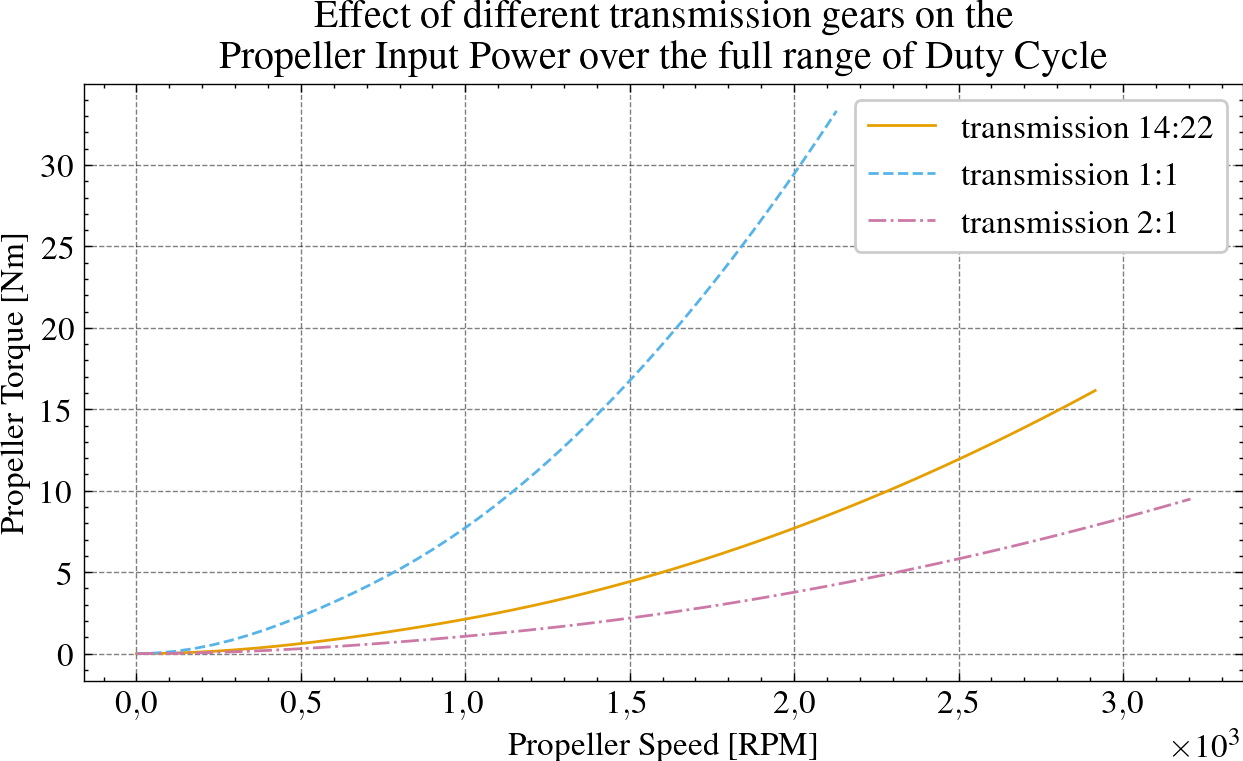

In [10]:
plt.figure()
plt.plot(results_transmission_1['motor_w'] * 30 / np.pi, results_transmission_1['motor_q_load'], label='transmission 14:22')
plt.plot(results_transmission_2['motor_w'] * 30 / np.pi, results_transmission_2['motor_q_load'], label='transmission 1:1')
plt.plot(results_transmission_3['motor_w'] * 30 / np.pi, results_transmission_3['motor_q_load'], label='transmission 2:1')
plt.xlabel("Propeller Speed [RPM]")
plt.ylabel("Propeller Torque [Nm]")
plt.title("Effect of different transmission gears on the \nPropeller Input Power over the full range of Duty Cycle")
plt.legend()
plt.show();

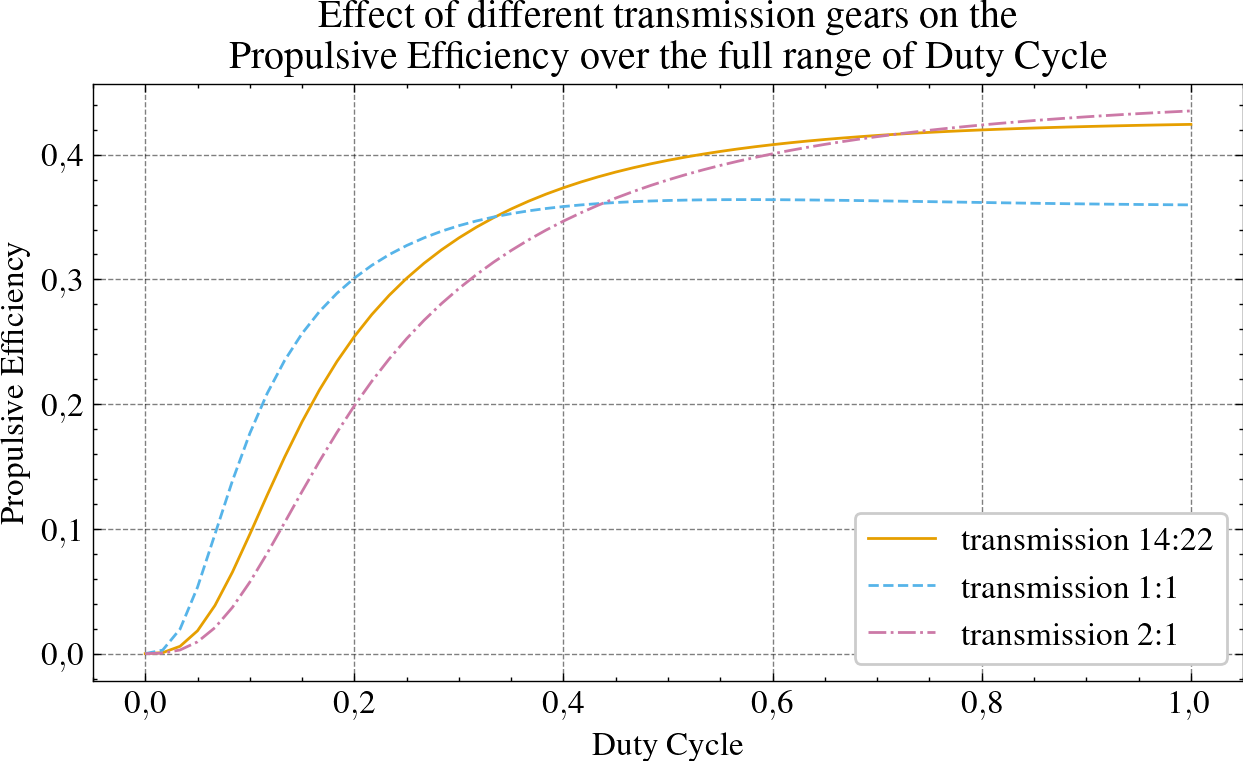

In [11]:
plt.figure()
plt.plot(results_transmission_1['esc_d'], results_transmission_1['prop_p_in'] / results_transmission_1['batt_p'], label='transmission 14:22')
plt.plot(results_transmission_2['esc_d'], results_transmission_2['prop_p_in'] / results_transmission_2['batt_p'], label='transmission 1:1')
plt.plot(results_transmission_3['esc_d'], results_transmission_3['prop_p_in'] / results_transmission_3['batt_p'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Propulsive Efficiency")
plt.title("Effect of different transmission gears on the \nPropulsive Efficiency over the full range of Duty Cycle")
plt.legend()
plt.show();

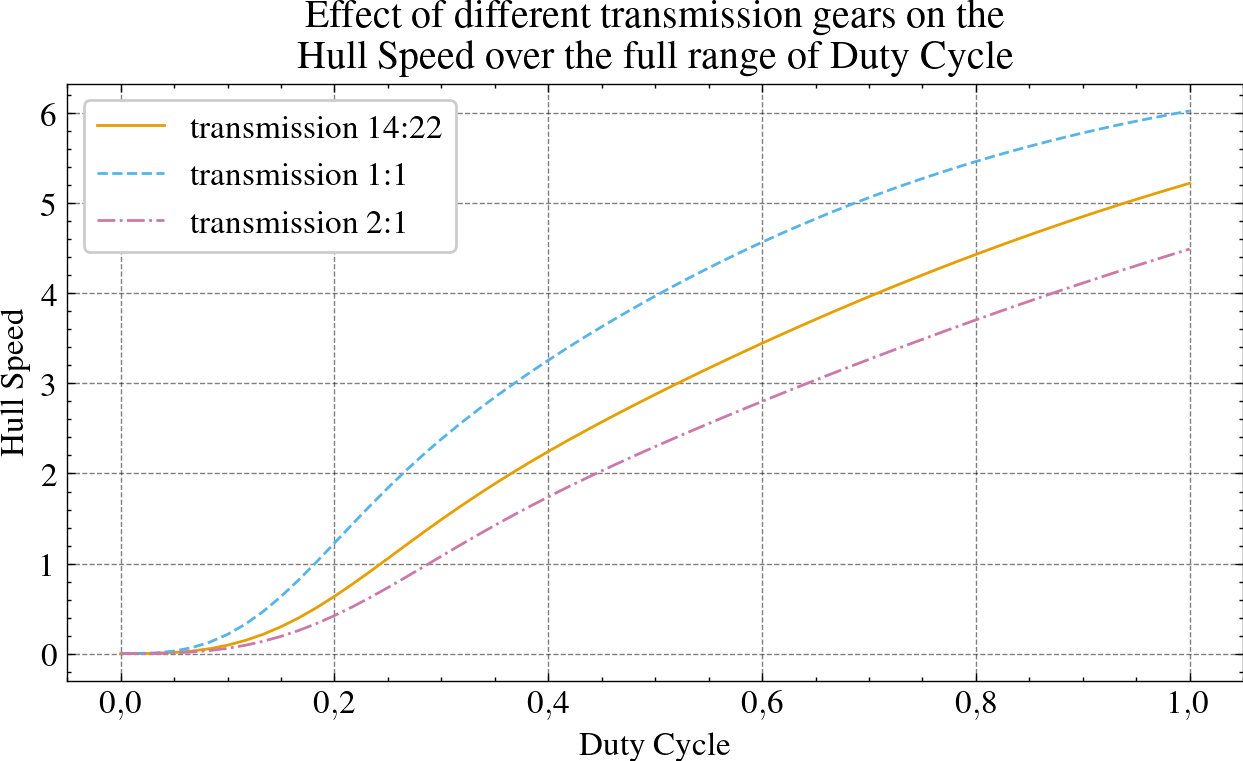

In [12]:
plt.figure()
plt.plot(results_transmission_1['esc_d'], results_transmission_1['hull_u'], label='transmission 14:22')
plt.plot(results_transmission_2['esc_d'], results_transmission_2['hull_u'], label='transmission 1:1')
plt.plot(results_transmission_3['esc_d'], results_transmission_3['hull_u'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Hull Speed")
plt.title("Effect of different transmission gears on the \nHull Speed over the full range of Duty Cycle")
plt.legend()
plt.show();

In [19]:
def add_wh_per_km(df: pd.DataFrame) -> pd.DataFrame:
    required_cols = ['esc_p_in', 'hull_u', 'esc_d']
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise KeyError(f'Missing required columns: {missing}')

    out = df.dropna(subset=required_cols).copy()
    # Avoid blow-ups / sign issues
    out = out[(out['hull_u'] > 0.2) & (out['esc_p_in'] > 1.0)].copy()

    out['boat_e_wh_per_km'] = (out['esc_p_in'] / out['hull_u']) * (1000.0 / 3600.0)
    out['wh_per_km'] = out['boat_e_wh_per_km']
    return out

df_km_1 = add_wh_per_km(results_transmission_1)
df_km_2 = add_wh_per_km(results_transmission_2)
df_km_3 = add_wh_per_km(results_transmission_3)

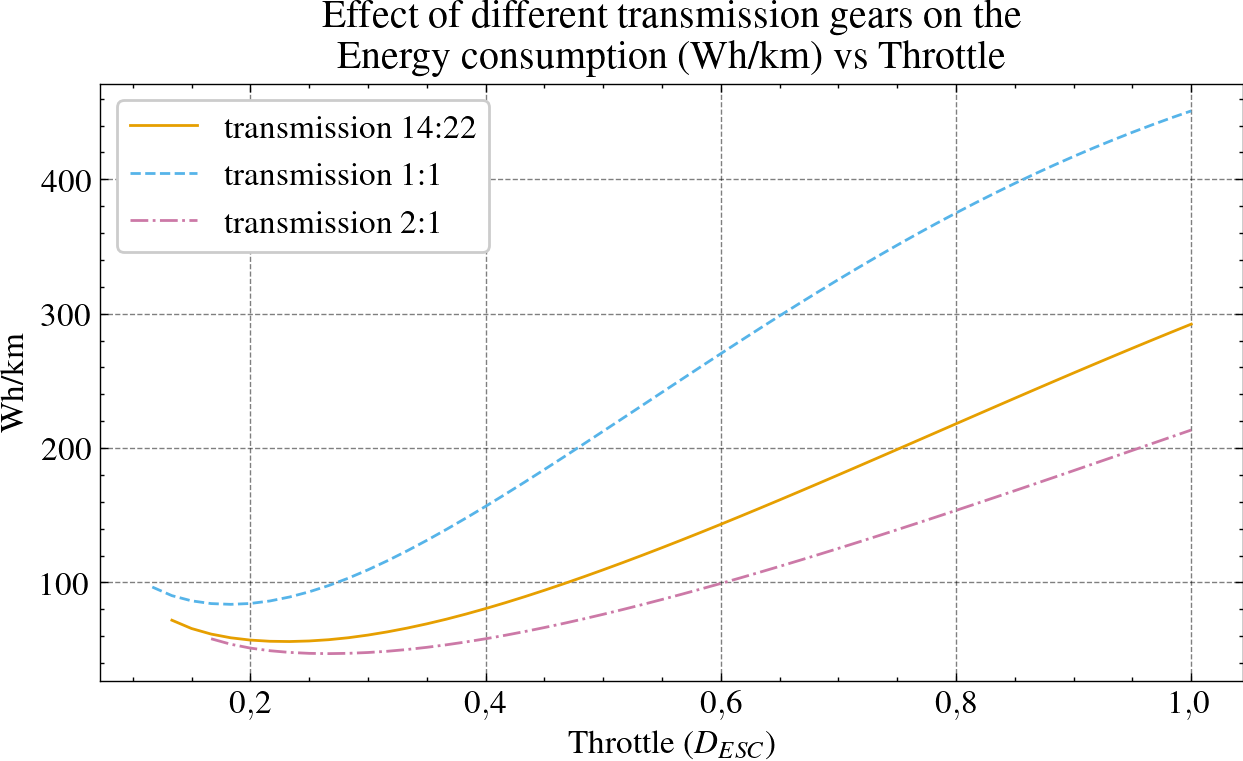

In [ ]:
#  Bin by throttle for cleaner curves
u_min = float(np.nanmin([df_km_1['esc_d'].min(), df_km_2['esc_d'].min(), df_km_3['esc_d'].min()]))
u_max = float(np.nanmax([df_km_1['esc_d'].max(), df_km_2['esc_d'].max(), df_km_3['esc_d'].max()]))
u_bins = np.linspace(u_min, u_max, 60)

def bin_mean(df: pd.DataFrame, label: str) -> pd.DataFrame:
    b = df.copy()
    b['esc_d_bin'] = pd.cut(b['esc_d'], bins=u_bins)
    return (
        b.groupby('esc_d_bin', observed=True)
        .agg(esc_d=('esc_d', 'mean'), wh_per_km=('wh_per_km', 'mean'))
        .dropna()
        .sort_values('esc_d')
        .assign(label=label)
    )

df_b1 = bin_mean(df_km_1, 'transmission 14:22')
df_b2 = bin_mean(df_km_2, 'transmission 1:1')
df_b3 = bin_mean(df_km_3, 'transmission 2:1')

plt.figure()
plt.plot(df_b1['esc_d'], df_b1['wh_per_km'], label=df_b1['label'].iloc[0])
plt.plot(df_b2['esc_d'], df_b2['wh_per_km'], label=df_b2['label'].iloc[0])
plt.plot(df_b3['esc_d'], df_b3['wh_per_km'], label=df_b3['label'].iloc[0])
plt.xlabel('Throttle ($D_{ESC}$)')
plt.ylabel('Wh/km')
plt.title('Effect of different transmission gears on the\nEnergy consumption (Wh/km) vs Throttle')
plt.grid(True)
plt.legend()
plt.show()

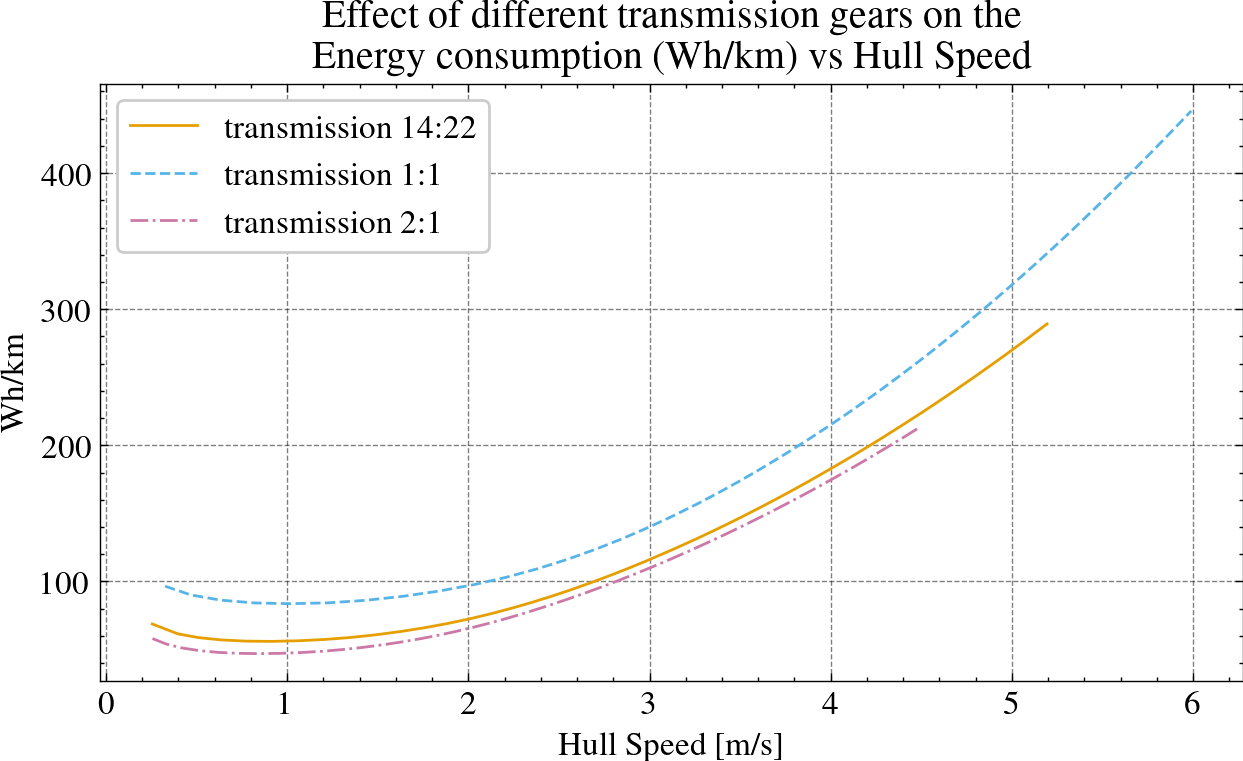

In [ ]:
# Bin by hull speed for cleaner curves
u_min = float(np.nanmin([df_km_1['hull_u'].min(), df_km_2['hull_u'].min(), df_km_3['hull_u'].min()]))
u_max = float(np.nanmax([df_km_1['hull_u'].max(), df_km_2['hull_u'].max(), df_km_3['hull_u'].max()]))
u_bins = np.linspace(u_min, u_max, 60)

def bin_mean(df: pd.DataFrame, label: str) -> pd.DataFrame:
    b = df.copy()
    b['hull_u_bin'] = pd.cut(b['hull_u'], bins=u_bins)
    return (
        b.groupby('hull_u_bin', observed=True)
        .agg(hull_u=('hull_u', 'mean'), wh_per_km=('wh_per_km', 'mean'))
        .dropna()
        .sort_values('hull_u')
        .assign(label=label)
    )

df_b1 = bin_mean(df_km_1, 'transmission 14:22')
df_b2 = bin_mean(df_km_2, 'transmission 1:1')
df_b3 = bin_mean(df_km_3, 'transmission 2:1')

plt.figure()
plt.plot(df_b1['hull_u'], df_b1['wh_per_km'], label=df_b1['label'].iloc[0])
plt.plot(df_b2['hull_u'], df_b2['wh_per_km'], label=df_b2['label'].iloc[0])
plt.plot(df_b3['hull_u'], df_b3['wh_per_km'], label=df_b3['label'].iloc[0])
plt.xlabel('Hull Speed [m/s]')
plt.ylabel('Wh/km')
plt.title('Effect of different transmission gears on the\nEnergy consumption (Wh/km) vs Hull Speed')
plt.grid(True)
plt.legend()
plt.show();